### A hierarchical model

Suppose ***scholastic aptitude (SA)***, denoted $u$, is distributed normally in the population with mean $\mu_0$ and variance $\sigma_0^2$:
$$
u\sim N(\mu_0, \sigma_0^2)
$$

The random variable $u$ is ***latent*** &mdash; unobservable.

A person's ***Scholastic Aptitute Test (SAT)*** score, denoted $y$, is supposed to reflect their scholastic aptitute $u$. Assume:
$$
y\mid u \sim N(u, \sigma^2)
$$
Thus, $\sigma$ is a reflection of the SAT's measurement error.

Variance in SAT score in the population has two sources: variation in SA across the population ($\sigma_0$) and variation in SAT scores among people with the same SA ($\sigma$). By *The Theory*, these two sources of variation combine additively:
$$
y\sim N(\mu_0,\sigma_0^2 + \sigma^2)
$$

### An application of Bayes' Theorem

What can we say about someone's SA if we know their test score? More precisely, what is $p(u\mid y)$?

By Bayes' Theorem,
$$
p(u\mid y) = \frac{p(y\mid u)p(u)}{p(y)}.
$$

We know $p(u)$, $p(y\mid u)$, and $p(y)$. With some algebraic perseverance, we manipulate the right hand side of the the above identify into standard Gaussian form and identify its mean and variance.

Set
$$
\tau_0 = \frac1{\sigma_0},\qquad \tau= \frac1{\sigma}.
$$
The reciprocal variances $\tau_0^2$ and $\tau$^2 are called ***precisions***.

We have:
$$
\begin{aligned}
\mathbb{E}[u\mid y] &= \frac{\tau_0^2}{\tau_0^2 + \tau^2}\mu_0 + \frac{\tau^2}{\tau_0^2 + \tau^2}y\\
\mathbb{V}[u\mid y] &= \frac{1}{\tau_0^2 + \tau^2}
\end{aligned}
$$

Let $\theta$ be the ratio of uncertainty in scholastic aptitude to uncertainty in SAT results.
$$
\theta = \frac{\sigma_0}{\sigma} = \frac{\tau}{\tau_0}.
$$
(The larger $\theta$ is, the more reliable the SAT for capturing the latent SA quantity.)

Setting
$$
t = \frac{1}{1 + \theta^2}
$$
we have
$$
\mathbb{E}[u\mid y] = t\mu_0 + (1 - t)y.
$$

The expression on the right hand side lies between $\mu_0$ and $y$.

If $\theta$ is small, $\mathbb{E}[u\mid y]$ is close to $\mu_0$. Makes sense: If $\theta$ is small then the SAT score $y$ isn't a reliable reflection of SA $u$ we hedge our bet for $u$ towards the population mean.

If $\theta$ is big, $\mathbb{E}[u\mid y]$ is close to $y$. Makes sense: If $\theta$ is big then the SAT score $y$ is a reliable reflection of SA $u$ and we don't need to hedge our bets.


### More generally

You might draw many $y$ subordinate to the same draw of $u$:

$$
\begin{aligned}
u_i&\sim N(\mu_0, \sigma_0^2),&&i<m,\\
y_{ij}\mid u_i &\sim N(u_i,\sigma^2),&&j < n_i
\end{aligned}
$$

Two draws $y_{ij}$ and $y_{ij'}$ are identically distributed and conditionally independent, given $u_i$, but not independent.

Later, we'll discuss how to estimate the parameters of such a model 

In [52]:
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
from statsmodels.api import MixedLM
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


mu0 = 20
sigma0 = 5
sigma = 3
m = 7

cat_dtype = pd.CategoricalDtype(categories=np.arange(m))


def make_data(n, rng=None):
    rng = np.random.default_rng(rng)
    u = rng.normal(mu0, sigma0, size=m)
    i = rng.choice(range(m), size=n)
    y = rng.normal(u[i], sigma)
    df = pd.DataFrame({"y": y, "i": i, "Intercept": 1})
    df["i"] = df["i"].astype(cat_dtype)
    return df


df_train = make_data(30)
df_test = make_data(10_000)
df_train.head()

,y,i,Intercept
0,17.500510,0,1
1,30.510661,6,1
2,14.099756,4,1
3,20.082010,3,1
4,16.329387,1,1


In [53]:
y_train = df_train["y"]
X_train = pd.get_dummies(df_train["i"])
assert X_train.shape[1] == 7

y_test = df_test["y"]
X_test = pd.get_dummies(df_test["i"])
assert X_train.shape[1] == 7

lr_model = LinearRegression(fit_intercept=False)
lr_model.fit(X_train, y_train)
test_mse = mean_squared_error(y_test, lr_model.predict(X_test))
test_mse

49.14887433608354

In [57]:
mixed_model = MixedLM(df_train["y"], df_train[["Intercept"]], groups=df_train["i"])
fit = mixed_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: y       
No. Observations: 30      Method:             REML    
No. Groups:       7       Scale:              9.0400  
Min. group size:  2       Log-Likelihood:     -82.2354
Max. group size:  7       Converged:          Yes     
Mean group size:  4.3                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   21.200    1.994 10.629 0.000 17.291 25.109
Group Var   25.395    5.941                           
======================================================

"""

In [55]:
assert np.allclose(df_train.groupby("i", observed=False)["y"].mean(), lr_model.coef_)

In [42]:
mixed_preds = fit.params["Intercept"] + df_test["i"].map(
    lambda i: fit.random_effects[i]["Group Var"]
).astype(float)
test_mse = mean_squared_error(y_test, mixed_preds)
test_mse

136.45090563906143

In [69]:
fe_mses = []
re_mses = []

for _ in range(1000):
    df_train = make_data(30)
    y_train = df_train["y"]
    X_train = pd.get_dummies(df_train["i"])
    assert X_train.shape[1] == 7

    y_test = df_test["y"]
    X_test = pd.get_dummies(df_test["i"])
    assert X_train.shape[1] == 7

    lr_model = LinearRegression(fit_intercept=False)
    lr_model.fit(X_train, y_train)
    assert np.allclose(
        df_train.groupby("i", observed=False)["y"].mean().fillna(0.0), lr_model.coef_
    )
    fe_mse = mean_squared_error(y_test, lr_model.predict(X_test))
    fe_mses.append(fe_mse)

    mixed_model = MixedLM(df_train["y"], df_train[["Intercept"]], groups=df_train["i"])
    fit = mixed_model.fit()

    mixed_preds = fit.params["Intercept"] + df_test["i"].map(
        lambda i: fit.random_effects[i]["Group Var"] if i in fit.random_effects else 0.0
    ).astype(float)
    re_mse = mean_squared_error(y_test, mixed_preds)
    re_mses.append(re_mse)

/Users/mgreenbe/DATA335W2025/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mgreenbe/DATA335W2025/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/mgreenbe/DATA335W2025/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mgreenbe/DATA335W2025/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/mgreenbe/DATA335W2025/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum

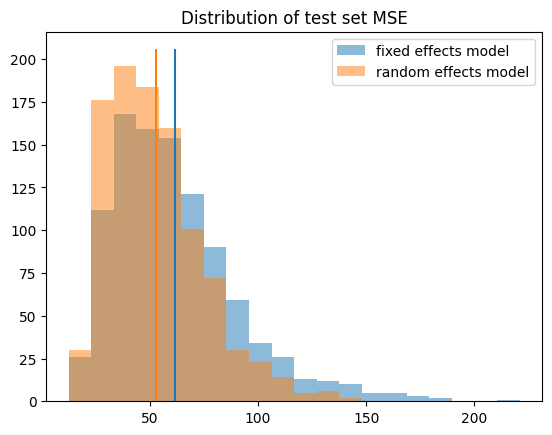

In [70]:
_, bins, __ = plt.hist(fe_mses, bins=20, alpha=0.5, label="fixed effects model")
plt.hist(re_mses, bins=bins, alpha=0.5, label="random effects model")
plt.vlines([np.mean(fe_mses), np.mean(re_mses)], *plt.ylim(), colors=["C0", "C1"])
plt.title("Distribution of test set MSE")
plt.legend()
plt.show()

In [71]:
# Get radon data
path = "https://raw.githubusercontent.com/pymc-devs/pymc-examples/main/examples/data/srrs2.dat"
radon_df = pd.read_csv(path)

# Strip spaces from column names
radon_df.columns = radon_df.columns.map(str.strip)

# Filter to keep observations for "MN" state only
radon_df = radon_df[radon_df.state == "MN"].copy()

radon_df

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county
5080,5081,MN,MN,27,55735,5,1,1,3,N,...,930,12088,12288,2.2,9.7,1146.499190,1,0,1,AITKIN
5081,5082,MN,MN,27,55748,5,1,0,4,Y,...,1615,11888,12088,2.2,14.5,471.366223,0,0,1,AITKIN
5082,5083,MN,MN,27,55748,5,1,0,4,Y,...,1515,20288,21188,2.9,9.6,433.316718,0,0,1,AITKIN
5083,5084,MN,MN,27,56469,5,1,0,4,Y,...,1410,122987,123187,1.0,24.3,461.623670,0,0,1,AITKIN
5084,5085,MN,MN,27,55011,3,1,0,4,Y,...,600,12888,13088,3.1,13.8,433.316718,0,0,3,ANOKA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5994,5995,MN,MN,27,55363,5,1,0,4,Y,...,1730,122687,122887,6.4,4.5,1146.499190,0,0,171,WRIGHT
5995,5996,MN,MN,27,55376,5,1,0,7,Y,...,700,121787,121987,4.5,8.3,1105.956867,0,0,171,WRIGHT
5996,5997,MN,MN,27,55376,5,1,0,4,Y,...,1045,12888,13088,5.0,5.2,1214.922779,0,0,171,WRIGHT
5997,5998,MN,MN,27,56297,5,1,0,4,Y,...,940,122887,123087,3.7,9.6,1177.377355,0,0,173,YELLOW MEDICINE


In [72]:
# Add a FIPS column
radon_df["fips"] = 1_000 * radon_df.stfips + radon_df.cntyfips
radon_df["fips"]

5080    27001
5081    27001
5082    27001
5083    27001
5084    27003
        ...  
5994    27171
5995    27171
5996    27171
5997    27173
5998    27173
Name: fips, Length: 919, dtype: int64

In [74]:
import pymc as pm

# Get city data
city_df = pd.read_csv(pm.get_data("cty.dat"))

# Add FIPS column
city_df["fips"] = 1_000 * city_df.stfips + city_df.ctfips

city_df

,stfips,ctfips,st,cty,lon,lat,Uppm,fips
0,1,1,AL,AUTAUGA,-86.643,32.534,1.78331,1001
1,1,3,AL,BALDWIN,-87.750,30.661,1.38323,1003
2,1,5,AL,BARBOUR,-85.393,31.870,2.10105,1005
3,1,7,AL,BIBB,-87.126,32.998,1.67313,1007
4,1,9,AL,BLOUNT,-86.568,33.981,1.88501,1009
...,...,...,...,...,...,...,...,...
3189,56,37,WY,SWEETWATER,-108.879,41.660,2.42132,56037
3190,56,39,WY,TETON,-110.589,43.934,2.39226,56039
3191,56,41,WY,UINTA,-110.547,41.288,2.31204,56041
3192,56,43,WY,WASHAKIE,-107.682,43.905,2.63989,56043


In [75]:
# Merge data
df = radon_df.merge(city_df[["fips", "Uppm"]], on="fips", how="left")
df = df.drop_duplicates(subset="idnum")

# Clean county names
df.county = df.county.map(str.strip)

# Compute log(radon + 0.1)
df["log_radon"] = np.log(df["activity"] + 0.1)

# Let's map floor 0 -> "Basement" and floor 1 -> "Floor"
df["floor"] = df["floor"].map({0: "Basement", 1: "Floor"})

# Sort values by floor
df = df.sort_values(by="floor")

# Reset index
df = df.reset_index(drop=True)

df

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,log_radon
0,5540,MN,MN,27,56031,5,1,Basement,4,Y,...,4.1,5.6,1177.377355,0,0,91,MARTIN,27091,1.180410,1.435085
1,5665,MN,MN,27,55110,3,1,Basement,4,Y,...,2.7,11.0,2314.365189,0,0,123,RAMSEY,27123,0.658327,1.029619
2,5666,MN,MN,27,55112,3,1,Basement,4,Y,...,1.2,16.7,2116.561544,0,0,123,RAMSEY,27123,0.658327,0.262364
3,5667,MN,MN,27,55112,3,1,Basement,2,Y,...,3.5,6.5,2116.561544,0,0,123,RAMSEY,27123,0.658327,1.280934
4,5668,MN,MN,27,55113,3,1,Basement,2,Y,...,5.5,5.3,2179.503255,0,0,123,RAMSEY,27123,0.658327,1.722767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,5757,MN,MN,27,55731,1,1,Floor,3,Y,...,0.5,29.7,461.274696,0,0,137,ST LOUIS,27137,0.622088,-0.510826
915,5759,MN,MN,27,55732,1,1,Floor,1,Y,...,1.6,11.3,461.274696,0,0,137,ST LOUIS,27137,0.622088,0.530628
916,5765,MN,MN,27,55741,1,1,Floor,3,Y,...,0.9,35.3,461.623670,0,0,137,ST LOUIS,27137,0.622088,0.000000
917,5718,MN,MN,27,55044,5,1,Floor,1,N,...,9.1,3.7,461.274696,0,0,139,SCOTT,27139,1.065150,2.219203


In [ ]:
small_df = df.loc[df["floor"] == "Basement", ["log_radon", "county"]]
small_df["Intercept"] = 1.0

In [ ]:
mixed_model = MixedLM(
    small_df["log_radon"], small_df[["Intercept"]], groups=small_df["county"]
)
fit = mixed_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: log_radon
No. Observations: 766     Method:             REML     
No. Groups:       85      Scale:              0.4527   
Min. group size:  1       Log-Likelihood:     -824.0279
Max. group size:  100     Converged:          Yes      
Mean group size:  9.0                                  
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     1.494    0.053 28.377 0.000  1.391  1.597
Group Var     0.125    0.052                           
=======================================================

"""

In [86]:
fit.random_effects

{'AITKIN': Group Var   -0.370765
 dtype: float64,
 'ANOKA': Group Var   -0.503776
 dtype: float64,
 'BECKER': Group Var   -0.002718
 dtype: float64,
 'BELTRAMI': Group Var    0.102549
 dtype: float64,
 'BENTON': Group Var   -0.06827
 dtype: float64,
 'BIG STONE': Group Var    0.019305
 dtype: float64,
 'BLUE EARTH': Group Var    0.29428
 dtype: float64,
 'BROWN': Group Var    0.222464
 dtype: float64,
 'CARLTON': Group Var   -0.4294
 dtype: float64,
 'CARVER': Group Var    0.13365
 dtype: float64,
 'CASS': Group Var   -0.038316
 dtype: float64,
 'CHIPPEWA': Group Var    0.137309
 dtype: float64,
 'CHISAGO': Group Var   -0.255285
 dtype: float64,
 'CLAY': Group Var    0.455265
 dtype: float64,
 'CLEARWATER': Group Var   -0.08586
 dtype: float64,
 'COOK': Group Var   -0.276219
 dtype: float64,
 'COTTONWOOD': Group Var    0.094598
 dtype: float64,
 'CROW WING': Group Var   -0.361467
 dtype: float64,
 'DAKOTA': Group Var   -0.102646
 dtype: float64,
 'DODGE': Group Var    0.146147
 dtype: 